<a href="https://colab.research.google.com/github/dfu2020/ATMS597_Project6_groupF/blob/master/Project6_Re_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt  
import glob
import xarray as xr
!pip install netcdf4
!pip install pydap

!apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
!pip install Cython
!pip install --upgrade --force-reinstall shapely --no-binary shapely
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 327kB 28.8MB/s 
     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 122kB 19.3MB/s 
Selecting previously unselected package libgeos-dev.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up libproj-dev:amd64 (4.9.3-2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 358kB 2.7MB/s 
Skipping wheel build

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#!mkdir '/content/drive/My Drive/project6_data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Project_6/project6_data

/content/drive/.shortcut-targets-by-id/1YU5xEkvTgnu0YdzoNXYwrJKN9yF-LsDq/project6_data


### Add the target variable to the master dataframe to train the model

In [0]:
master_df=pd.read_csv('project6_masterDF.csv')

In [5]:
master_df

,Unnamed: 0,lat,lon,SWflux(W/m2),LWflux(W/m2),Uwnd_sfc(m/s),Vwnd_sfc(m/s),Uwnd_250mb(m/s),Vwnd_250mb(m/s),Omega_500mb(mb/day),SpecHum_850mb(*1/1000 kg/kg),Sfc_Temp(K),MSLP(mb),month
0,0,90,-180,0.00000,210.13225,-2.380642,-0.434673,2.131622,4.500654,0.003288,0.000758,246.46739,1009.84827,1
1,1,90,-179,0.00000,210.01935,-2.393545,-0.358868,2.331300,4.400653,0.003288,0.000758,246.47968,1009.84827,1
2,2,90,-178,0.00000,209.82259,-2.408868,-0.277416,2.520009,4.301299,0.003288,0.000758,246.50932,1009.84827,1
3,3,90,-177,0.00000,209.75485,-2.420965,-0.200803,2.697105,4.184846,0.003288,0.000758,246.53775,1009.84827,1
4,4,90,-176,0.00000,209.58707,-2.430641,-0.115319,2.882589,4.066783,0.003288,0.000758,246.54518,1009.84827,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331195,64795,-89,175,476.62903,468.77420,-3.023387,3.438710,20.120163,5.246775,-0.039468,0.002896,301.49033,993.21130,12
9331196,64796,-89,176,476.59677,469.58066,-2.716129,2.889516,20.648386,4.380645,-0.034266,0.002895,301.68710,993.02260,12
9331197,64797,-89,177,476.58066,470.79030,-2.749194,1.977419,20.944353,3.638710,-0.032315,0.002853,301.88870,993.14343,12
9331198,64798,-89,178,476.60483,470.30646,-2.901613,1.090323,21.108065,2.981452,-0.034589,0.002805,301.90643,993.46860,12


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Read master_df from file if not already loaded to memory
#master_df = pd.read_csv('/content/drive/My Drive/project6_data/project6_masterDF.csv')
master_df = pd.read_csv('project6_masterDF.csv')
master_df = master_df.loc[:, ~master_df.columns.str.contains('^Unnamed')]

def gather_modis_variable_train(variable):
    '''Read the files of all months of all training years and append the
    values of given variable into a single array.

    Input:
    variable (String) :: Name of column corresponding to required variable in
        MODIS input files

    Output:
    mod (float; Pandas DataFrame) :: Array of values of variable from all files 
      appended together.
    '''
    years = np.arange(2005,2020,1)
    years = list(filter(lambda a: a != 2007 and a != 2013 and a != 2015 , years))
    mod = pd.DataFrame()
    for yr in years:
      print(yr)
      for mn in range(1,13):
        A = pd.read_csv('MODIS_'+str(yr)+'_'+str(mn)+'.txt')
        mod = pd.concat([mod,A[variable]])
    
    return mod

mod_train = gather_modis_variable_train('Re_mean') # For a different MODIS variable, change to appropriate dataframe header
mod_train.columns = ['Var']
mod_train = mod_train.reset_index(drop=True)

2005
2006
2008
2009
2010
2011
2012
2014
2016
2017
2018
2019


In [0]:
mod_train.tail()

,Var
9331195,7.59
9331196,8.05
9331197,8.61
9331198,8.44
9331199,9.38


In [0]:
master_df.tail()

,lat,lon,SWflux(W/m2),LWflux(W/m2),Uwnd_sfc(m/s),Vwnd_sfc(m/s),Uwnd_250mb(m/s),Vwnd_250mb(m/s),Omega_500mb(mb/day),SpecHum_850mb(*1/1000 kg/kg),Sfc_Temp(K),MSLP(mb),month
9331195,-89,175,476.62903,468.77420,-3.023387,3.438710,20.120163,5.246775,-0.039468,0.002896,301.49033,993.21130,12
9331196,-89,176,476.59677,469.58066,-2.716129,2.889516,20.648386,4.380645,-0.034266,0.002895,301.68710,993.02260,12
9331197,-89,177,476.58066,470.79030,-2.749194,1.977419,20.944353,3.638710,-0.032315,0.002853,301.88870,993.14343,12
9331198,-89,178,476.60483,470.30646,-2.901613,1.090323,21.108065,2.981452,-0.034589,0.002805,301.90643,993.46860,12
9331199,-89,179,476.60483,469.17743,-2.970161,0.675806,21.191936,2.326613,-0.039895,0.002770,301.53387,994.06445,12


## Neural Network Model

## Define the training, test and target datasets

In [8]:
unif = np.random.uniform(0, np.shape(master_df)[0], int(0.7*np.shape(master_df)[0]))
train_dataset = master_df.iloc[unif]
print('Sampled training set from input data randomly - 70% by volume....')
test_dataset = master_df[~master_df.index.isin(unif)]
print('Sampled test set from input data randomly - 30% by volume....')
train_labels = mod_train.iloc[unif]
test_labels = mod_train[~mod_train.index.isin(unif)]
print('Generated target variable from training and test data sets....')

Sampled training set from input data randomly - 70% by volume....
Sampled test set from input data randomly - 30% by volume....
Generated target variable from training and test data sets....


In [0]:
train_labels

,Var
640843,11.94
6936794,-99.99
1001487,17.72
3561606,-99.99
4275667,-99.99
...,...
624477,17.09
1990748,19.25
1641188,12.76
7273668,13.60


In [0]:
train_dataset

,lat,lon,SWflux(W/m2),LWflux(W/m2),Uwnd_sfc(m/s),Vwnd_sfc(m/s),Uwnd_250mb(m/s),Vwnd_250mb(m/s),Omega_500mb(mb/day),SpecHum_850mb(*1/1000 kg/kg),Sfc_Temp(K),MSLP(mb),month
640843,-70,-137,173.183880,338.01932,1.678229,1.335486,-9.588379,-1.107733,-0.043647,0.011270,277.24094,1009.75195,10
6936794,82,134,37.524193,272.41130,-1.788710,1.848387,45.884678,2.841130,-0.022177,0.004418,259.33710,1021.56120,12
1001487,9,147,343.393250,464.65000,-4.289998,2.678337,26.489012,-4.586991,-0.023002,0.002887,301.04364,992.59564,4
3561606,-83,-54,418.429100,427.86133,1.283875,0.649197,3.339684,1.869363,0.029804,0.000085,294.24582,1014.33980,7
4275667,-86,127,365.376740,464.53333,-5.268331,0.793337,3.823340,1.277341,0.000998,0.002504,300.82327,1014.16565,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624477,-24,57,271.351560,386.79352,-0.466126,1.183874,4.415814,-4.674508,-0.028454,0.000413,287.03577,979.45355,10
1990748,-39,128,313.738680,459.22580,-6.554027,2.574197,-3.358056,0.113557,0.019385,0.009399,300.04575,1012.24480,7
1641188,32,128,114.520690,221.69308,1.815520,0.050865,-0.689303,-8.432751,0.012757,0.000601,249.51240,1011.70520,2
7273668,46,48,5.645161,304.05646,-0.537097,-3.224193,2.347581,-1.341129,0.002927,0.011280,271.31290,1011.32020,5


## Build the ANN regression model

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train_dataset.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,657
Trainable params: 166,657
Non-trainable params: 0
_________________________________________________________________


## Define checkpoints for the training epochs

In [0]:
checkpoint_name = 'project6_dataWeights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [0]:
#Originally run with 10 epochs
NN_model.fit(train_dataset, train_labels, epochs=5, batch_size=64, validation_split = 0.2, callbacks=callbacks_list)
NN_model.save('CTH_NN_model_DF.h5')

Train on 5225472 samples, validate on 1306368 samples
Epoch 1/5
5225472/5225472 [==============================] - 257s 49us/step - loss: 4.5669 - mean_absolute_error: 4.5669 - val_loss: 3.3596 - val_mean_absolute_error: 3.3596

Epoch 00001: val_loss improved from inf to 3.35959, saving model to project6_dataWeights-001--3.35959.hdf5
Epoch 2/5
5225472/5225472 [==============================] - 254s 49us/step - loss: 3.2955 - mean_absolute_error: 3.2955 - val_loss: 2.9694 - val_mean_absolute_error: 2.9694

Epoch 00002: val_loss improved from 3.35959 to 2.96938, saving model to project6_dataWeights-002--2.96938.hdf5
Epoch 3/5
5225472/5225472 [==============================] - 254s 49us/step - loss: 3.0663 - mean_absolute_error: 3.0663 - val_loss: 2.6725 - val_mean_absolute_error: 2.6725

Epoch 00003: val_loss improved from 2.96938 to 2.67249, saving model to project6_dataWeights-003--2.67249.hdf5
Epoch 4/5
5225472/5225472 [==============================] - 255s 49us/step - loss: 2.9372 -

## Training Details for CTH model

Average training period per epoch = 434 s = 7.23 min <br>
Best Model = '/content/drive/My Drive/project6_dataWeights-005--0.68639.hdf5' (Epoch 5) <br>
Model Mean Errors : <br>
loss: 0.7092 <br>
mean_absolute_error: 0.7092 <br>
val_loss: 0.6864 <br>
val_mean_absolute_error: 0.6864 

#### Evolution of Training and Validation Losses with Epochs

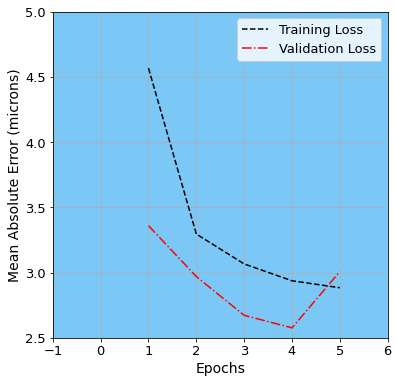

In [0]:
training_loss = [4.5669,3.2955,3.0663,2.9372, 2.8837]
validation_loss = [3.3596 ,2.9694, 2.6725,2.5763,3.0068]
epochs = np.arange(1,6)

plt.figure(figsize=(6,6))
plt.plot(epochs, training_loss, color='k', linestyle='--', label='Training Loss')
plt.plot(epochs, validation_loss, color='r', linestyle='-.', label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.gca().set_facecolor('xkcd:lightblue')
plt.ylim(2.5,5)
plt.xlim(-1,6)
plt.ylabel('Mean Absolute Error (microns)', fontsize=14)
plt.legend(fontsize=13)
plt.grid('on')

for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(13)

plt.show()

2.9372 2.5763

In [0]:
# Load weights of the best model :
weights_file = 'project6_dataWeights-004--2.57626.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file)
print('Loaded model weights from hdf4 file....')

# Adam Optimizer, RMSE
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print('Compiled loss functions from weights file....')
print('Evaluating Loaded Model on Test Data....')
score = NN_model.evaluate(test_dataset, test_labels, verbose=0)
print("%s: %.2f%%" % (NN_model.metrics_names[1], score[1]*100))

# Adam Optimizer, Binary Cross-Entropy
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])
print('Compiled loss functions from weights file....')
print('Evaluating Loaded Model on Test Data....')
score = NN_model.evaluate(test_dataset, test_labels, verbose=0)
print("%s: %.2f%%" % (NN_model.metrics_names[1], score[1]*100))

# RMSProp Optimizer, Accuracy
NN_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print('Compiled loss functions from weights file....')
print('Evaluating Loaded Model on Test Data....')
score = NN_model.evaluate(test_dataset, test_labels, verbose=0)
print("%s: %.2f%%" % (NN_model.metrics_names[1], score[1]*100))

Loaded model weights from hdf4 file....
Compiled loss functions from weights file....
Evaluating Loaded Model on Test Data....
mean_absolute_error: 258.11%
Compiled loss functions from weights file....
Evaluating Loaded Model on Test Data....
binary_crossentropy: -33387.62%
Compiled loss functions from weights file....
Evaluating Loaded Model on Test Data....
accuracy: 0.26%


Loaded model weights from hdf4 file....


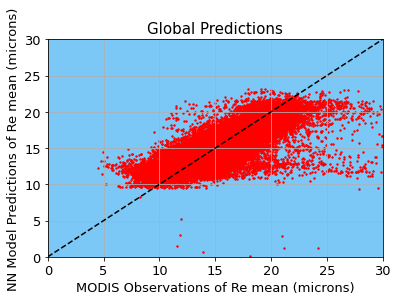

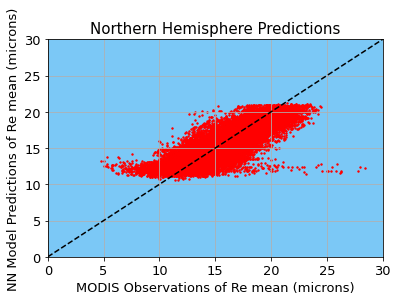

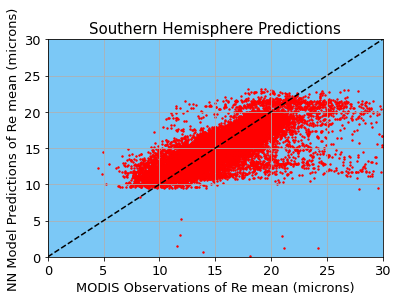

In [16]:
def return_month_data(yr,mn):
  # Let us test the outputs for a month of data from an El-Nino year (2008 August)
  X_input = pd.DataFrame(columns=['lat','lon','SWflux(W/m2)','LWflux(W/m2)','Uwnd_sfc(m/s)','Vwnd_sfc(m/s)','Uwnd_250mb(m/s)',\
                                  'Vwnd_250mb(m/s)','Omega_500mb(mb/day)','SpecHum_850mb(*1/1000 kg/kg)','Sfc_Temp(K)','MSLP(mb)','month'])
  A = pd.read_csv('Reanalysis_input_'+str(yr)+'_'+str(mn)+'.txt')
  A['month'] = 8
  X_input = pd.concat([X_input,A])

  Y_output = pd.DataFrame()
  A = pd.read_csv('MODIS_'+str(yr)+'_'+str(mn)+'.txt')
  Y_output = pd.concat([Y_output,A['Re_mean']])
  Y_output.columns = ['Var']
  Y_output = Y_output.reset_index(drop=True)

  return X_input,Y_output

def plot_regression(Y_output,Y_new,title):
  # print(Y_output.shape,Y_new.shape)
  xx=np.arange(0.,31.,1.)
  plt.scatter(Y_output['Var'][:], Y_new[:,0], color='r', s=2)
  plt.plot(xx,xx,'k',linestyle='--')
  plt.grid('on')
  plt.xlim(0,30.)
  plt.ylim(0,30.)
  plt.title(title,fontsize=15)
  plt.xlabel('MODIS Observations of Re mean (microns)', fontsize = 13)
  plt.ylabel('NN Model Predictions of Re mean (microns)', fontsize = 13)
  plt.gca().set_facecolor('xkcd:lightblue')
  for tick in plt.gca().yaxis.get_major_ticks():
      tick.label.set_fontsize(13)
  for tick in plt.gca().xaxis.get_major_ticks():
      tick.label.set_fontsize(13)

  plt.show()  

# Load weights of the best model :
weights_file = 'project6_dataWeights-004--2.57626.hdf5' # choose the best checkpoint 
#weights_file = 'project6_dataWeights-004--0.68261.hdf5'
NN_model.load_weights(weights_file)
print('Loaded model weights from hdf4 file....')
X_input,Y_output = return_month_data(2007,8)
#Generate Model Predictions for a month of data:
Y_new = NN_model.predict(X_input)
plot_regression(Y_output,Y_new,'Global Predictions')
#Generate Model Predictions for a month of data (Northern Hemisphere):
plot_regression(Y_output.head(int(np.shape(Y_output)[0]/2.)),Y_new[0:int(np.shape(Y_output)[0]/2.),:],
                'Northern Hemisphere Predictions')
#Generate Model Predictions for a month of data (Southern Hemisphere):
plot_regression(Y_output.tail(int(np.shape(Y_output)[0]/2.)),Y_new[int(np.shape(Y_output)[0]/2.):np.shape(Y_output)[0],:],
                'Southern Hemisphere Predictions')



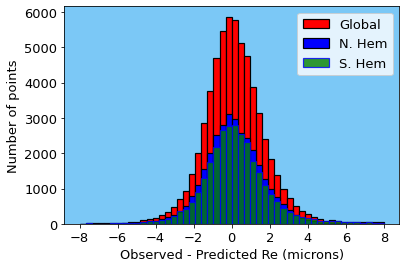

In [17]:
Y_output['Var'][Y_output['Var']<0]=np.nan
Y_new[np.where(Y_new[:,0]<0),0]=np.nan
plt.hist(Y_output['Var'][:]-Y_new[:,0],range=(-8.,8.),bins=50,edgecolor='black',color='r',linewidth=1.2, label='Global')
plt.hist(Y_output.head(int(np.shape(Y_output)[0]/2.))['Var'][:]-Y_new[0:int(np.shape(Y_output)[0]/2.),0],range=(-8.,8.),bins=50,
         edgecolor='black',color='b',linewidth=1.2, label='N. Hem')
plt.hist(Y_output.tail(int(np.shape(Y_output)[0]/2.))['Var'][:]-Y_new[int(np.shape(Y_output)[0]/2.):np.shape(Y_output)[0],0],
         range=(-8.,8.),bins=50,edgecolor='b',color='g', alpha=0.8, linewidth=1.2,label='S. Hem')
plt.xlabel('Observed - Predicted Re (microns)', fontsize = 13)
plt.ylabel('Number of points', fontsize = 13)
plt.gca().set_facecolor('xkcd:lightblue')
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in plt.gca().xaxis.get_major_ticks():
      tick.label.set_fontsize(13)
plt.legend(fontsize=13)
plt.show()

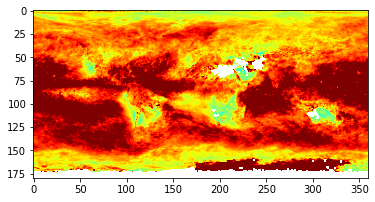

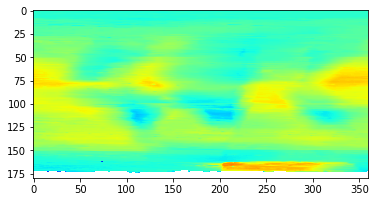

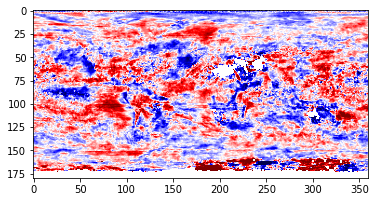

In [22]:
cth_gridded = np.reshape(Y_output['Var'].values, (180,360))
plt.imshow(cth_gridded, vmin=0, vmax=30., cmap='jet')
plt.clim(0.,18.)
plt.show()
cth_gridded_new = np.reshape(Y_new[:,0], (180,360))
plt.imshow(cth_gridded_new, vmin=0, vmax=30., cmap='jet')
plt.clim(0.,30.)
plt.show()
plt.imshow(cth_gridded - cth_gridded_new, vmin=-5, vmax=5., cmap='seismic')
# plt.clim(0.,18.)
plt.show()

In [0]:
Y_new.shape

(64800, 1)

In [0]:
cth_gridded = np.reshape(Y_output['Var'].values, (180,360))

cth_gridded_new = np.reshape(Y_new[:,0], (180,360))

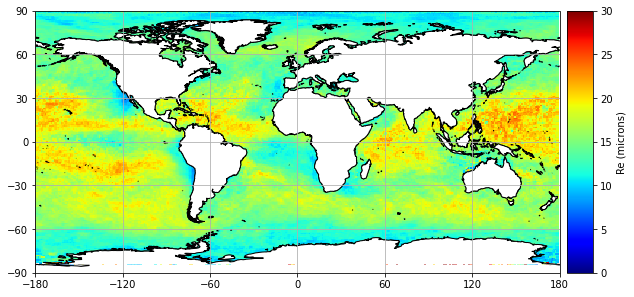

In [24]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import cartopy
from cartopy import config
from cartopy import feature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
#
proj = ccrs.PlateCarree()


#ax = plt.axes(projection=ccrs.PlateCarree())
f, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=proj))
lon=np.arange(-180,180,1)
lat=np.arange(-90,90,1)
h = ax.pcolormesh(lon, -lat, cth_gridded, vmin=0, vmax=30, cmap='jet',transform=proj)
ax.coastlines()


feature = feature.NaturalEarthFeature(name='coastline', category='physical',
                                              scale='50m',
                                              facecolor='white',edgecolor='black')
ax.set_xticks(np.linspace(-180, 180, 7), crs=proj)
ax.set_yticks(np.linspace(-90, 90, 7), crs=proj)
ax.add_feature(feature)
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f', 
#               facecolor='#B1B2B4')
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

f.add_axes(ax_cb)
plt.colorbar(h, cax=ax_cb,label='Re (microns)')
ax.gridlines()

plt.show()


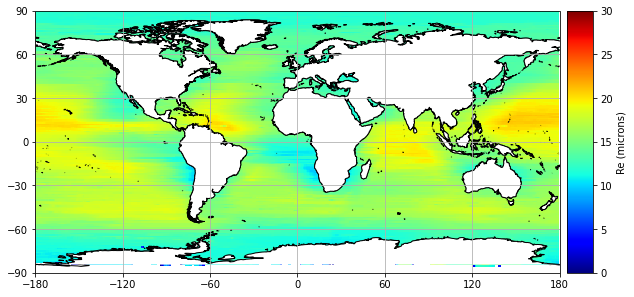

In [27]:
f, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=proj))

h = ax.pcolormesh(lon, -lat, cth_gridded_new, vmin=0, vmax=30, cmap='jet',transform=proj)
ax.coastlines()
ax.set_xticks(np.linspace(-180, 180, 7), crs=proj)
ax.set_yticks(np.linspace(-90, 90, 7), crs=proj)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

f.add_axes(ax_cb)
plt.colorbar(h, cax=ax_cb,label='Re (microns)')
ax.gridlines()
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f', 
#               facecolor='#B1B2B4')
ax.add_feature(feature)

plt.show()

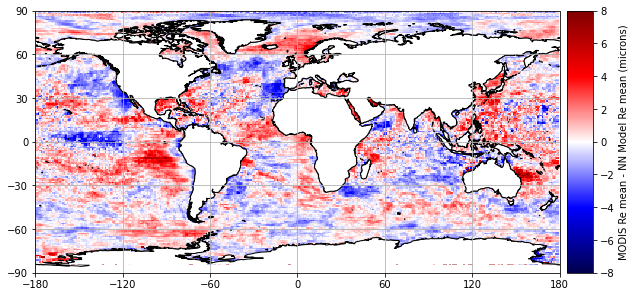

In [28]:
f, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=proj))

h = ax.pcolormesh(lon, -lat, cth_gridded-cth_gridded_new, vmin=-8, vmax=8, cmap='seismic',transform=proj)
ax.coastlines()
ax.set_xticks(np.linspace(-180, 180, 7), crs=proj)
ax.set_yticks(np.linspace(-90, 90, 7), crs=proj)
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f', 
#               facecolor='#B1B2B4')
ax.add_feature(feature)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

f.add_axes(ax_cb)
plt.colorbar(h, cax=ax_cb,label='MODIS Re mean - NN Model Re mean (microns)')
ax.gridlines()

plt.show()

In [0]:
#Long-term August means
cth_gridded_lt = np.zeros((180,360))
c = np.zeros((180,360))
for yr in range(2005,2020):
  A = pd.read_csv('MODIS_'+str(yr)+'_8.txt')
  cth = A['Re_mean'].values
  cth[np.where(cth<0.)] = np.nan
  cth_gridded_lt = cth_gridded_lt + np.reshape(cth, (180,360))
  c.ravel()[np.where(np.isnan(cth)==False)]=c.ravel()[np.where(np.isnan(cth)==False)]+1
cth_gridded_lt = cth_gridded_lt/c

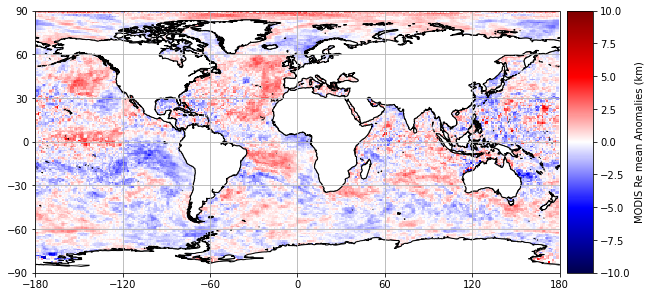

In [30]:
f, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=proj))

h = ax.pcolormesh(lon, -lat, cth_gridded_lt-cth_gridded, vmin=-10, vmax=10, cmap='seismic',transform=proj)
ax.coastlines()
ax.set_xticks(np.linspace(-180, 180, 7), crs=proj)
ax.set_yticks(np.linspace(-90, 90, 7), crs=proj)
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f', 
#               facecolor='#B1B2B4')
ax.add_feature(feature)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

f.add_axes(ax_cb)
plt.colorbar(h, cax=ax_cb,label='MODIS Re mean Anomalies (km)')
ax.gridlines()

plt.show()

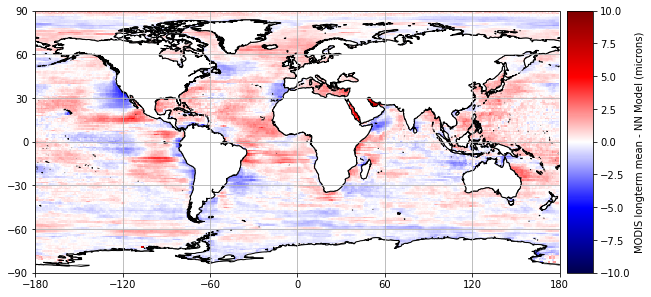

In [34]:
f, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=proj))

h = ax.pcolormesh(lon, -lat, cth_gridded_lt-cth_gridded_new, vmin=-10, vmax=10, cmap='seismic',transform=proj)
ax.coastlines()
ax.set_xticks(np.linspace(-180, 180, 7), crs=proj)
ax.set_yticks(np.linspace(-90, 90, 7), crs=proj)
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f', 
#               facecolor='#B1B2B4')
ax.add_feature(feature)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

f.add_axes(ax_cb)
plt.colorbar(h, cax=ax_cb,label='MODIS longterm mean - NN Model (microns)')
ax.gridlines()

plt.show()

In [0]:
plt.style.use('default')
plt.rcParams.update({'font.size': 14})
plt.show()